In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
%matplotlib inline

### Chargement des datasets

In [13]:
X_test = pd.read_csv("../data/X_test_update.csv", index_col=0)
X_train = pd.read_csv("../data/X_train_update.csv", index_col = 0)

In [14]:
X_train.head()

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB


Il y a énormément de valuers manquantes pour la variable description.

In [17]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13812 entries, 84916 to 98727
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  13812 non-null  object
 1   description  8926 non-null   object
 2   productid    13812 non-null  int64 
 3   imageid      13812 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 539.5+ KB


In [22]:
y_train = pd.read_csv("../data/Y_train_CVw08PX.csv", index_col=0)

In [24]:
y_train.head()

,prdtypecode
0,10
1,2280
2,50
3,1280
4,2705


In [26]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB


In [28]:
print(len(y_train.value_counts()))

27


Il y a 27 Product type codes différents à prédire.

In [31]:
# prompt: déplacerle fichier images.zip dans le dossier /content

import shutil

# Source path of the zip file in Google Drive
source_path = "/content/drive/MyDrive/Alternance_Datascientest/Projet_DS/images.zip"  # Replace with the actual path

# Destination path in /content
destination_path = "/content/images.zip"


# Check if the source file exists
if os.path.exists(source_path):
    try:
        shutil.copy2(source_path, destination_path)  # copy2 preserves metadata
        print(f"File '{source_path}' successfully copied to '{destination_path}'")
    except shutil.SameFileError:
        print(f"Source and destination represent the same file.")
    except PermissionError:
        print(f"Permission denied when trying to copy '{source_path}'.")
    except Exception as e:  # Handle other potential errors
        print(f"An error occurred during file copy: {e}")
else:
    print(f"Source file '{source_path}' not found.")

Source file '/content/drive/MyDrive/Alternance_Datascientest/Projet_DS/images.zip' not found.


In [33]:
os.chdir("/content")

FileNotFoundError: [WinError 2] Le fichier spécifié est introuvable: '/content'

In [35]:
# prompt: unzip le fichier /content/images.zip

!unzip /content/images.zip


'unzip' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


Les images sont toutes de tailles (500,500,3)

### Exploration des images

In [39]:
# Relancez la cellule pour afficher une image différente
row = np.random.randint(len(X_train))
plt.imshow(plt.imread(f"images/image_train/image_{X_train.iloc[row]['imageid']}_product_{X_train.iloc[row]['productid']}.jpg", format="jpg"))
plt.title(f"{X_train.iloc[row]['designation']}")
plt.axis("off")
plt.show()
print("prdtypecode: ",y_train.prdtypecode[row])

FileNotFoundError: [Errno 2] No such file or directory: 'images/image_train/image_1225410273_product_3589914266.jpg'

In [ ]:
img = plt.imread(f"images/image_train/image_{X_train.iloc[row]['imageid']}_product_{X_train.iloc[row]['productid']}.jpg")
img.reshape(1,-1).shape

In [ ]:
imgs: np.ndarray
imgs = None
for img_path in os.listdir("images/image_train"):
    img = plt.imread(fname=f"images/image_train/{img_path}", format="jpg")
    img_flat = img.reshape(1,-1)
    if imgs is None:
        imgs = img_flat
    else:
        imgs = np.concatenate((imgs, img_flat), axis=0)
print(imgs.shape)

### Visualisation et exploration des données textuelles

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np

nltk.download('stopwords')
nltk.download('wordnet')

def generate_wordcloud(X_train, y_train, categories, colormap='viridis'):
    """
    Generates a word cloud with the 5 most redundant words for each category,
    using distinct colors from the specified colormap.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        categories (list): List of product type codes to include.
        colormap (str): Name of the matplotlib colormap to use.
    """

    # Create a color dictionary for each category (0-255 for WordCloud)
    colors = plt.get_cmap(colormap)(np.linspace(0, 1, len(categories)))
    category_colors_wordcloud = {cat: tuple(int(round(c * 255)) for c in color[:3])
                                 for cat, color in zip(categories, colors)}

    # Create a separate color dictionary for the legend (0-1 for matplotlib)
    category_colors_legend = {cat: color[:3]
                              for cat, color in zip(categories, colors)}

    all_words = []

    for category in categories:
        # Merge, drop NA, and filter by category
        merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
        merged_df = merged_df.dropna(subset=['description'])
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"No descriptions found for category '{category}'.")
            continue

        # Combine descriptions, preprocess, and count words
        text = " ".join(category_df['description'].astype(str))
        stop_words = set(stopwords.words('french'))
        lemmatizer = WordNetLemmatizer()

        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]

        # Get the 5 most common words
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(5))
        for word, count in top_words.items():
            all_words.append({'word': word, 'size': count, 'color': category_colors_wordcloud[category], 'category': category})
        # ...

    # Create WordCloud object (using category_colors_wordcloud)
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          color_func=lambda word, **kwargs: all_words[[w['word'] for w in all_words].index(word)]['color'])

    # Generate word cloud from all_words
    wordcloud.generate_from_frequencies({w['word']: w['size'] for w in all_words})

    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Categories")

    # Add legend (using category_colors_legend)
    # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=cat,
    #                               markerfacecolor=color, markersize=10)
    #                    for cat, color in category_colors_legend.items()]
    # plt.legend(handles=legend_elements, title="Categories", loc='upper left')

    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flore\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flore\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


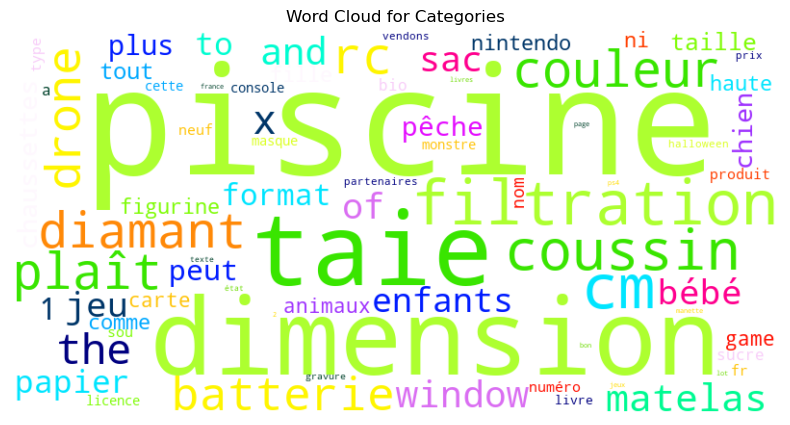

In [45]:
generate_wordcloud(X_train,y_train,y_train.prdtypecode.unique(),colormap='gist_ncar')

### Wordcloud par catégorie

In [48]:
def generate_categorical_wordcloud(X_train, y_train, category):
    """
    Generates a word cloud from the 'description' column of X_train,
    filtered by a specific category in the 'prdtypecode' column of y_train.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        category (str): The product type code to filter by.
    """
    # Merge X_train and y_train based on the common index
    merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

    # Remove rows with missing descriptions
    merged_df = merged_df.dropna(subset=['description'])

    # Filter by category
    category_df = merged_df[merged_df['prdtypecode'] == category]

    if category_df.empty:
        print(f"No descriptions found for category '{category}'.")
        return

    # Combine all descriptions into a single string
    text = " ".join(category_df['description'].astype(str))

    # Preprocess the text
    stop_words = set(stopwords.words('french')) # Assuming French text
    lemmatizer = WordNetLemmatizer()

    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]
    processed_text = " ".join(words)

    # Create and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(processed_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Category: {category}")
    plt.show()

In [49]:
# Affichage des catégories pour pouvoir explorer les différents nuages de mots
print(y_train.prdtypecode.unique())

[  10 2280   50 1280 2705 2522 2582 1560 1281 1920 2403 1140 2583 1180
 1300 2462 1160 2060   40   60 1320 1302 2220 2905 2585 1940 1301]


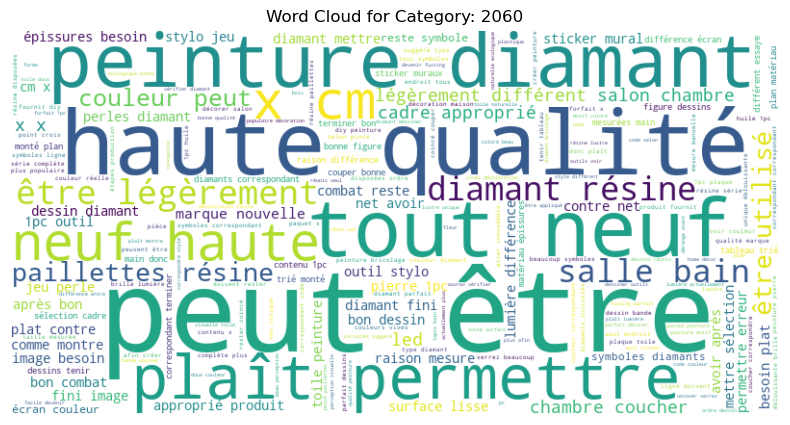

In [50]:
generate_categorical_wordcloud(X_train,y_train,category = 2060)

In [79]:
import plotly.graph_objects as go
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib.pyplot


#nltk.download('stopwords')
#nltk.download('wordnet')

def generate_interactive_wordcloud(X_train, y_train, categories, colormap='viridis'):
    """
    Generates an interactive word cloud with Plotly, allowing category selection.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        categories (list): List of product type codes to include.
        colormap (str): Name of the matplotlib colormap to use.
    """
    colors = plt.get_cmap(colormap)(np.linspace(0, 1, len(categories)))
    category_colors = {cat: tuple(int(round(c * 255)) for c in color[:3])
                      for cat, color in zip(categories, colors)}

    all_words = []

    for category in categories:
        merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
        merged_df = merged_df.dropna(subset=['description'])
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"No descriptions found for category '{category}'.")
            continue

        text = " ".join(category_df['description'].astype(str))
        stop_words = set(stopwords.words('french'))
        lemmatizer = WordNetLemmatizer()

        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(5))

        for word, count in top_words.items():
            all_words.append({'word': word, 'size': count, 'color': category_colors[category], 'category': category})

    fig = go.Figure()

    for word_data in all_words:
        category_name = str(word_data['category'])
        fig.add_trace(go.Scatter(
            x=[np.random.uniform(-1, 1)],  # Positionnement aléatoire en x
            y=[np.random.uniform(-1, 1)],  # Positionnement aléatoire en y
            mode='text',
            text=[word_data['word']],
            textfont={'size': min(word_data['size'] * 2, 30),  # Taille ajustée avec une limite max
                      'color': f'rgb{word_data["color"]}'},
            name=category_name,
            visible=True
        ))

    fig.update_layout(
        title="Interactive Word Cloud",
        xaxis={'showgrid': False, 'zeroline': False, 'visible': False},
        yaxis={'showgrid': False, 'zeroline': False, 'visible': False},
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                active=0,
                x=0,
                y=1.1,
                buttons=list([
                    dict(label="All",
                         method="update",
                         args=[{"visible": [True] * len(all_words)},
                               {"title": "All Categories"}]),
                    *[dict(label=str(cat),
                           method="update",
                           args=[{"visible": [w['category'] == cat for w in all_words]},
                                 {"title": f"Category: {cat}"}]
                          ) for cat in categories]
                ])
            )
        ]
    )

    fig.show()

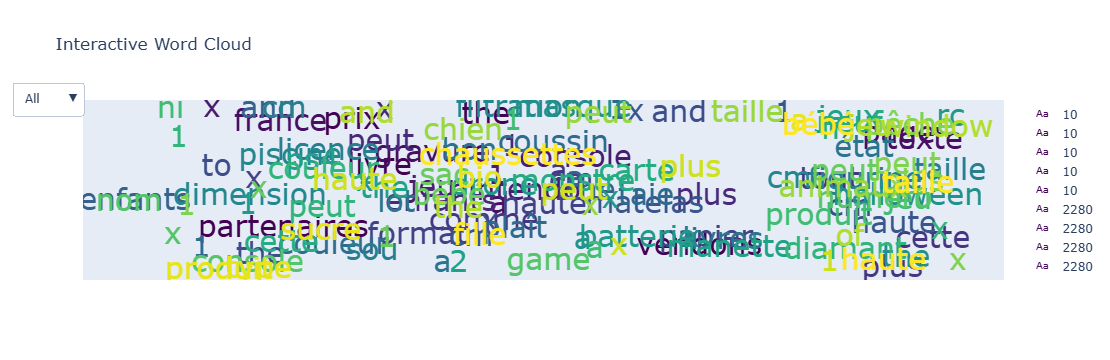

In [81]:
generate_interactive_wordcloud(X_train,y_train,y_train.prdtypecode.unique(),colormap='viridis')

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

def generate_wordcloud_top_words(X_train, y_train, categories, colormap='viridis'):
    """
    Generates a WordCloud for each category with the top 5 most cited words 
    and integrates it into Plotly for interactivity.

    Args:
        X_train (pd.DataFrame): DataFrame containing the 'description' column.
        y_train (pd.DataFrame): DataFrame containing the 'prdtypecode' column.
        categories (list): List of product type codes to include.
        colormap (str): Name of the matplotlib colormap to use.
    """
    # Merge descriptions and categories
    merged_df = pd.merge(X_train, y_train, left_index=True, right_index=True)
    merged_df = merged_df.dropna(subset=['description'])

    # Prepare stopwords and lemmatizer
    stop_words = set(stopwords.words('french'))
    lemmatizer = WordNetLemmatizer()

    # Placeholder for word clouds
    wordcloud_images = {}

    for category in categories:
        # Filter data by category
        category_df = merged_df[merged_df['prdtypecode'] == category]

        if category_df.empty:
            print(f"No descriptions found for category '{category}'.")
            continue

        # Combine descriptions, preprocess text
        text = " ".join(category_df['description'].astype(str))
        words = text.lower().split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalnum()]

        # Count word frequencies and keep the top 5
        word_counts = Counter(words)
        top_words = dict(word_counts.most_common(10))  # Keep only the top 10 words

        # Create word cloud for top 5 words
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color="white",
            colormap=colormap
        ).generate_from_frequencies(top_words)

        # Store the word cloud image
        wordcloud_images[category] = wordcloud

    # Plot the word clouds interactively with Plotly
    fig = go.Figure()

    for category, wordcloud in wordcloud_images.items():
        # Convert the WordCloud image to a format Plotly can display
        img = wordcloud.to_array()

        fig.add_trace(go.Image(z=img, name=str(category), visible=True))

    # Add dropdown menu for interactivity
    fig.update_layout(
        title="Interactive Word Cloud (Top 10 Words per Category)",
        updatemenus=[
            dict(
                type="dropdown",
                direction="down",
                x=0.5,
                y=1.15,
                buttons=[
                    dict(label="All",
                         method="update",
                         args=[{"visible": [True] * len(wordcloud_images)},
                               {"title": "All Categories"}]),
                    *[dict(label=str(cat),
                           method="update",
                           args=[{"visible": [cat == c for c in wordcloud_images.keys()]},
                                 {"title": f"Category: {cat}"}])
                      for cat in wordcloud_images.keys()]
                ]
            )
        ]
    )

    fig.show()


In [103]:
#generate_wordcloud_top_words(X_train,y_train,y_train.prdtypecode.unique(),colormap='viridis')

In [109]:
# Calculer le nombre de NaN et non-NaN
nan_count = X_train['description'].isna().sum()
not_nan_count = X_train['description'].notna().sum()

# Créer un DataFrame pour la visualisation
data_proportion = pd.DataFrame({
    'Category': ['NaN', 'Champs Remplis'],
    'Count': [nan_count, not_nan_count]
})
data_proportion

,Category,Count
0,NaN,29800
1,Champs Remplis,55116


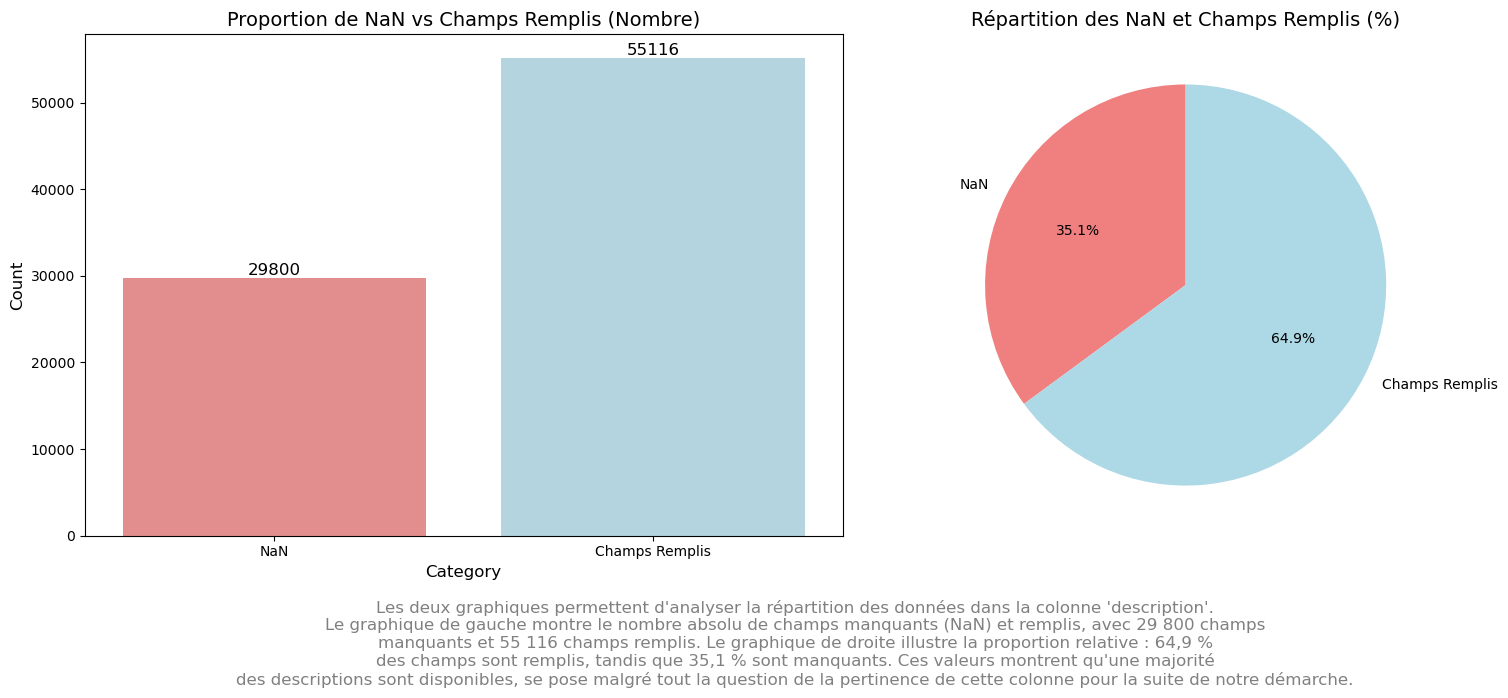

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer les proportions pour le camembert
labels = ['NaN', 'Champs Remplis']
sizes = [nan_count, not_nan_count]  # Les valeurs brutes pour chaque catégorie

# Définir les couleurs (les mêmes pour les deux graphiques)
colors = ['lightcoral', 'lightblue']

# Créer une figure avec deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 ligne, 2 colonnes

# Graphique 1 : Comptage des NaN et des Champs Remplis (Barplot)
sns.barplot(data=data_proportion, x='Category', y='Count', palette=colors, ax=axes[0])
axes[0].set_title('Proportion de NaN vs Champs Remplis (Nombre)', fontsize=14)
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Ajouter des annotations au-dessus des barres (Graphique 1)
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='bottom', fontsize=12, color='black')

# Graphique 2 : Camembert (Pie chart)
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Répartition des NaN et Champs Remplis (%)', fontsize=14)

# Ajouter une description sous les graphiques
fig.text(0.5, -0.15,
         "Les deux graphiques permettent d'analyser la répartition des données dans la colonne 'description'.\n"
         "Le graphique de gauche montre le nombre absolu de champs manquants (NaN) et remplis, avec 29 800 champs\n"
         "manquants et 55 116 champs remplis. Le graphique de droite illustre la proportion relative : 64,9 %\n"
         "des champs sont remplis, tandis que 35,1 % sont manquants. Ces valeurs montrent qu'une majorité\n"
         "des descriptions sont disponibles, se pose malgré tout la question de la pertinence de cette colonne pour la suite de notre démarche.",
         ha='center', fontsize=12, color='gray')

# Ajuster l'espace entre les graphiques
plt.tight_layout()

# Afficher les graphiques
plt.show()
